### Import all python Liberies

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt


### Create spark session and load json files spark Dataframe

In [2]:
spark = SparkSession.Builder().appName("Loan credit card").getOrCreate()

df= spark.read.json("datasets/cdw_sapp_custmer.json")

df.show(5)

+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States|WDunham@example.co

### Print details about the dataFrame

In [3]:
print(f"rows: {df.count()}")
print(len(df.columns))
df.describe().show()
df.printSchema()
df.columns

rows: 952
14
+-------+------------------+--------------------+---------+-------------+--------------------+------------------+----------+------------------+----------+---------+--------------------+-----------+--------------------+-----------+
|summary|            APT_NO|      CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|        CUST_PHONE|CUST_STATE|          CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|                 SSN|STREET_NAME|
+-------+------------------+--------------------+---------+-------------+--------------------+------------------+----------+------------------+----------+---------+--------------------+-----------+--------------------+-----------+
|  count|               952|                 952|      952|          952|                 952|               952|       952|               952|       952|      952|                 952|        952|                 952|        952|
|   mean| 507.3382352941176|4.210653353718597...|     null|    

['APT_NO',
 'CREDIT_CARD_NO',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'STREET_NAME']

### Typecasting Datatypes

In [4]:
df = df.withColumn("CUST_PHONE", col("CUST_PHONE").cast(StringType()))
df = df.withColumn("SSN", col("SSN").cast(IntegerType()))
df = df.withColumn("CUST_ZIP", col("CUST_ZIP").cast(IntegerType()))
df = df.withColumn("LAST_UPDATED", col("LAST_UPDATED").cast(TimestampType()))


df.dtypes

[('APT_NO', 'string'),
 ('CREDIT_CARD_NO', 'string'),
 ('CUST_CITY', 'string'),
 ('CUST_COUNTRY', 'string'),
 ('CUST_EMAIL', 'string'),
 ('CUST_PHONE', 'string'),
 ('CUST_STATE', 'string'),
 ('CUST_ZIP', 'int'),
 ('FIRST_NAME', 'string'),
 ('LAST_NAME', 'string'),
 ('LAST_UPDATED', 'timestamp'),
 ('MIDDLE_NAME', 'string'),
 ('SSN', 'int'),
 ('STREET_NAME', 'string')]

### Working with upper/lower cases

In [5]:
df = df.withColumn("FIRST_NAME", initcap("FIRST_NAME"))
df = df.withColumn("MIDDLE_NAME", lower("MIDDLE_NAME"))
df = df.withColumn("LAST_NAME", initcap("LAST_NAME"))

df.show()


+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21 12:49:02|         wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|    6109|      Etta|   Holman|2018-04-21 12:49:02|    brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States| WDunham@example.c

### Aggregating address

In [7]:
agg_address_df = df.withColumn("FULL_STREET_ADDRESS", concat(df["APT_NO"], lit(", "), df["STREET_NAME"]))

agg_address_df.show()

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21 12:49:02|         wm|123456100|Main Street North|656, Main Street ...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|    6109|      Etta|   Holman|2018-04-21 12:49:02|    brendan|123453023|    R

### Change the format of phone number to (XXX)XXX-XXXX

In [8]:
seed_rang =123

customer_df = agg_address_df.withColumn("CUST_PHONE",
                   concat(lit("("),
                          lpad((rand(seed=seed_rang) * 900 + 100).cast("int"), 3, "0"),
                          lit(") "),
                          substring(df.CUST_PHONE, 1, 3),
                          lit("-"),
                          substring(df.CUST_PHONE, 4, 3),
                          substring(df.CUST_PHONE, 7, 4)))

customer_df.show(truncate=False)

+------+----------------+------------+-------------+----------------------+--------------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+----------------------+
|APT_NO|CREDIT_CARD_NO  |CUST_CITY   |CUST_COUNTRY |CUST_EMAIL            |CUST_PHONE    |CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|LAST_UPDATED       |MIDDLE_NAME|SSN      |STREET_NAME      |FULL_STREET_ADDRESS   |
+------+----------------+------------+-------------+----------------------+--------------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+----------------------+
|656   |4210653310061055|Natchez     |United States|AHooper@example.com   |(242) 123-7818|MS        |39120   |Alec      |Hooper   |2018-04-21 12:49:02|wm         |123456100|Main Street North|656, Main Street North|
|829   |4210653310102868|Wethersfield|United States|EHolman@example.com   |(683) 123-8933|CT        |6109    |Etta      |Holman   |2018-04-2

### Drop colums

In [9]:
customer_df=customer_df.drop("STREET_NAME")
customer_df=customer_df.drop("APT_NO")

### Displaying data types

In [10]:
customer_df.dtypes
customer_df.show()

+----------------+------------+-------------+--------------------+--------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|    CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+------------+-------------+--------------------+--------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|4210653310061055|     Natchez|United States| AHooper@example.com|(242) 123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21 12:49:02|         wm|123456100|656, Main Street ...|
|4210653310102868|Wethersfield|United States| EHolman@example.com|(683) 123-8933|        CT|    6109|      Etta|   Holman|2018-04-21 12:49:02|    brendan|123453023|  829, Redwood Drive|
|4210653310116272|     Huntley|United States| WDunham@example.com|(957

### Rearranging the column

In [11]:
CDW_SAPP_CUSTOMER = customer_df.select("SSN","FIRST_NAME", "MIDDLE_NAME", "LAST_NAME","Credit_card_no","FULL_STREET_ADDRESS","CUST_CITY","CUST_STATE","CUST_COUNTRY","CUST_ZIP","CUST_PHONE","CUST_EMAIL","LAST_UPDATED")

### Display the Final DF

In [12]:
CDW_SAPP_CUSTOMER.show()

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+--------------+--------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|    CUST_PHONE|          CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+--------------+--------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|656, Main Street ...|     Natchez|        MS|United States|   39120|(242) 123-7818| AHooper@example.com|2018-04-21 12:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  829, Redwood Drive|Wethersfield|        CT|United States|    6109|(683) 123-8933| EHolman@example.com|2018-04-21 12:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|683, 12th

###                          Load data into MYSQL Database called creditcard_capstone

In [17]:
CDW_SAPP_CUSTOMER.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CUSTOMER") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

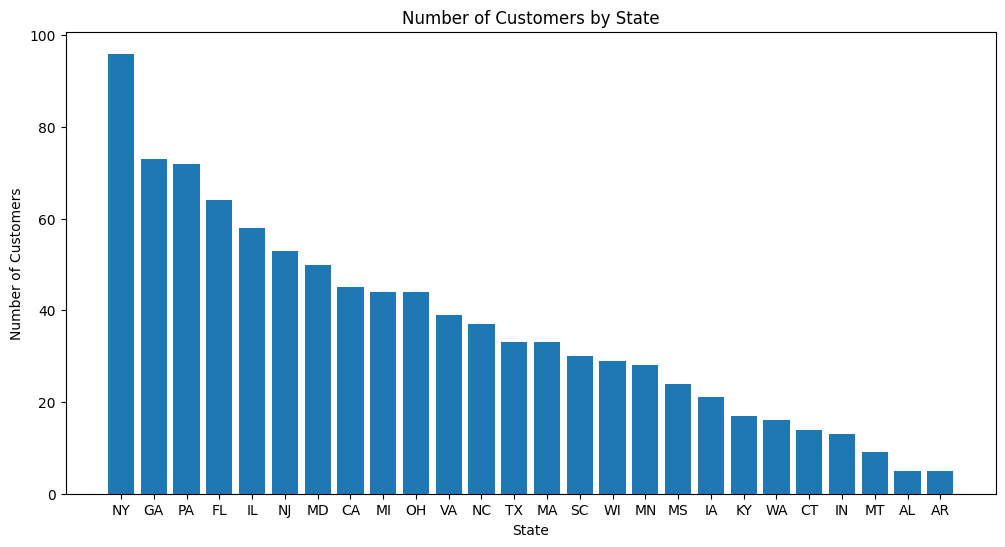

In [13]:
Customer_per_state = CDW_SAPP_CUSTOMER.groupBy("CUST_STATE").count()
Customer_per_state = Customer_per_state.orderBy(Customer_per_state["count"].desc())
state_counts_pd = Customer_per_state.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(state_counts_pd["CUST_STATE"], state_counts_pd["count"])
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.title("Number of Customers by State")
plt.show()